In [8]:
# Load required tudatpy modules
import numpy as np
from matplotlib import pyplot as plt
from tudatpy.data.horizons import HorizonsQuery
from tudatpy.interface import spice
from tudatpy.astro import time_conversion, element_conversion
from tudatpy.math import interpolators
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup, environment, propagation_setup, estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.numerical_simulation.environment import Tle
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from itertools import zip_longest
from tudatpy.util import result2array

spice.load_standard_kernels()

In [2]:
def sat_prop(
        simulation_start_epoch,
        simulation_end_epoch,
        target,
        target_TLE,
        target_initial_state = None,
        ):
    """
    Propogates the target object

    Parameters:
    simulation_start_epoch: float
        Simulation start epoch, in seconds from J2000
    simulation_end_epoch:
        Simulation end eopch, in sends from J000
    target: str
        Name of celestial body being observed
    target_TLE: tudatpy.kernel.numerical_simulation.environment.Tle object
        TLE of target object. Run TLE values through environment.Tle
    target_initial_state: numpy array
        Contains cartesian position and velocity of target's initial state

    Output:
    states_array: numpy array
        7 column array with time, position and velocities
    """


    # Define string names for bodies to be created from default.
    bodies_to_create = ["Sun", "Earth"]

    # Use "Earth"/"J2000" as global frame origin and orientation.
    global_frame_origin = "Earth"
    global_frame_orientation = "J2000"

    # Create default body settings
    body_settings = environment_setup.get_default_body_settings(
        bodies_to_create,
        global_frame_origin,
        global_frame_orientation)
    
    # Create empty body settings for the satellite
    body_settings.add_empty_settings(target)

    bodies = environment_setup.create_system_of_bodies(body_settings)
    # bodies.get(target).mass = 2.2 #kg
    # Define bodies that are propagated
    bodies_to_propagate = [target]

    # Define central bodies of propagation
    central_bodies = ["Earth"]

    # DEFINE ACCELERATIONS ACTING ON TARGET
    accelerations_settings_target = dict(
        Sun=[
            propagation_setup.acceleration.point_mass_gravity()
        ],
        Earth=[
            propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        ]
    )

    # Create global accelerations settings dictionary.
    acceleration_settings = {target: accelerations_settings_target}

    # Create acceleration models.
    acceleration_models = propagation_setup.create_acceleration_models(
        bodies,
        acceleration_settings,
        bodies_to_propagate,
        central_bodies)
    
    if target_initial_state is None:
        target_ephemeris = environment.TleEphemeris("Earth", "J2000", target_TLE, False)
        initial_state = target_ephemeris.cartesian_state(simulation_start_epoch)
    else:
        initial_state = target_initial_state

    

    # Create termination settings
    termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

    # Create numerical integrator settings
    fixed_step_size = 10.0
    integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step(
        fixed_step_size, coefficient_set=propagation_setup.integrator.CoefficientSets.rk_4
    )

    # Create propagation settings
    propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        initial_state,
        simulation_start_epoch,
        integrator_settings,
        termination_condition,
    )

    # Create simulation object and propagate the dynamics
    dynamics_simulator = numerical_simulation.create_dynamics_simulator(
        bodies, propagator_settings
    )

    # Extract the resulting state and dependent variable history and convert it to an ndarray
    states = dynamics_simulator.propagation_results.state_history
    states_array = result2array(states)

    return states_array

    

In [13]:
def tle_epoch_to_datetime(epoch_str: str) -> datetime:
    """
    Convert a TLE epoch string (YYDDD.FFFFFFFF) to a Python datetime in UTC.
    
    Parameters:
    -----------
    epoch_str : str
        TLE epoch in the format 'YYDDD.FFFFFFFFF', e.g., '25147.20450743'
    
    Returns:
    --------
    datetime (UTC)
    """
    # Parse year (YY)
    yy = int(epoch_str[:2])
    # TLE years: 00-56 => 2000-2056, 57-99 => 1957-1999
    year = 2000 + yy if yy < 57 else 1900 + yy
    
    # Parse day-of-year (DDD)
    day_of_year = int(epoch_str[2:5])
    
    # Fractional part of the day
    frac_day = float("0." + epoch_str.split('.', 1)[1])
    
    # Compute the base date (January 1 of year) + day offset
    base_date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
    # Add the fractional day as a timedelta
    full_date = base_date + timedelta(days=frac_day)

    # Round to the nearest second
    # Convert to seconds since UNIX epoch for rounding
    epoch_origin = datetime(1970, 1, 1)
    total_seconds = (full_date - epoch_origin).total_seconds()
    rounded_seconds = round(total_seconds)
    rounded_date = epoch_origin + timedelta(seconds=rounded_seconds)

    return rounded_date

In [ ]:
def plot_combined_elevation(
        target, 
        target_tle, 
        station_names, 
        start_epoch, 
        end_epoch, 
        time_step    = '10m',
        global_frame_origin      = 'Earth', 
        global_frame_orientation = 'J2000', 
        geodetic_positions       = None,
        custom_ephemeris         = None):
    """
    Plots the combined elevation of a target celestial body as seen from multiple ground stations,
    using a propagated orbit (via sat_prop) rather than Horizons.
    """

    # parse input times to Julian Day
    jd_start = time_conversion.calendar_date_to_julian_day(datetime.strptime(start_epoch, "%Y-%m-%d %H:%M:%S"))
    jd_end   = time_conversion.calendar_date_to_julian_day(datetime.strptime(end_epoch,   "%Y-%m-%d %H:%M:%S"))
    buffer_d = 1.0            # days
    # buffer for simulation ephemeris
    sim_jd_start = jd_start - buffer_d
    sim_jd_end   = jd_end   + buffer_d
    sim_t0 = time_conversion.julian_day_to_seconds_since_epoch(sim_jd_start)
    sim_t1 = time_conversion.julian_day_to_seconds_since_epoch(sim_jd_end)
    # true window in seconds-since-J2000 for plotting
    plot_t0 = time_conversion.julian_day_to_seconds_since_epoch(jd_start)
    plot_t1 = time_conversion.julian_day_to_seconds_since_epoch(jd_end)

    # 2) Build default Earth + empty target in BodySettings
    bodies_to_create = ["Earth"]
    body_settings = environment_setup.get_default_body_settings_time_limited(
        bodies_to_create, sim_t0, sim_t1, global_frame_origin, global_frame_orientation
    )
    body_settings.add_empty_settings(target)

    # 3) Inject the propagated orbit as a Tabulated Ephemeris
    if custom_ephemeris is not None:
        # if user passed a Tudat Ephemeris object directly
        body_settings.get(target).ephemeris_settings = custom_ephemeris
    else:
        # call your propagator
        states = sat_prop(sim_t0, sim_t1, target, target_tle)
        # build a dict: epoch_sec -> 6x1 Cartesian state
        state_dict = {
            float(row[0]): row[1:].reshape((6,1))
            for row in states
        }
        body_settings.get(target).ephemeris_settings = environment_setup.ephemeris.tabulated(
            state_dict, global_frame_origin, global_frame_orientation
        )

    # 4) Add your ground stations into Earth’s settings
    gs_settings = []
    for name in station_names:
        if geodetic_positions is None or name not in geodetic_positions:
            raise ValueError(f"No geodetic position for station '{name}'")
        alt, lat_deg, lon_deg = geodetic_positions[name]
        gs_settings.append(
            environment_setup.ground_station.basic_station(
                name,
                [ alt,
                  np.deg2rad(lat_deg),
                  np.deg2rad(lon_deg) ],
                element_conversion.geodetic_position_type
            )
        )
    body_settings.get("Earth").ground_station_settings = gs_settings

    # 5) Build the SystemOfBodies
    bodies = environment_setup.create_system_of_bodies(body_settings)

    # 6) Build epochs
    unit = time_step[-1]; value = float(time_step[:-1])
    dt = {'s':1, 'm':60, 'h':3600}[unit] * value
    epochs = np.arange(plot_t0, plot_t1 + dt, dt)

    # Prepare a figure
    fig, axes = plt.subplots(len(station_names), 1, figsize=(10, 3*len(station_names)), sharex=True)
    if len(station_names) == 1: axes = [axes]

    # 7) For each station, compute angles & plot
    for ax, station_name in zip(axes, station_names):
        # a) Link ends & LinkDefinition
        link_ends = {
            observation.receiver: 
                observation.body_reference_point_link_end_id("Earth", station_name)
        }
        link_def = observation.LinkDefinition(link_ends)

        # b) Compute az/el for all epochs
        station_id = ("Earth", station_name)
        angles_dict = estimation.compute_target_angles_and_range(
            bodies,
            station_id,
            target,
            observation_times=epochs,
            is_station_transmitting=False
        )
        tudat_azimuth_list = []
        tudat_elevation_list = []
        keys_list = sorted(angles_dict.keys())

        for idx_key, key in enumerate(keys_list):  # Ensure iteration follows sorted order
            azimuth_deg = np.rad2deg(angles_dict[key][1]) % 360
            elevation_deg = (np.rad2deg(angles_dict[key][0]) + 90) % 180 - 90  # Normalize elevation
            tudat_azimuth_list.append(azimuth_deg)
            tudat_elevation_list.append(elevation_deg)

        # c) Sort by time and extract elevation (rad → deg)
        times = np.array(sorted(angles_dict.keys()))

        azimuth_array = np.array(tudat_azimuth_list)
        elevation_array = np.array(tudat_elevation_list)

         # c) Plot elevation on the left y-axis
        ax.plot(times, elevation_array, color='tab:blue', label='Elevation')
        ax.axhline(0.0, color='gray', linestyle='--', linewidth=0.5)
        ax.set_ylabel("Elevation (°)", color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')

        # d) Create a twin axis for azimuth
        ax2 = ax.twinx()
        ax2.plot(times, azimuth_array, color='tab:red', label='Azimuth')
        ax2.set_ylabel("Azimuth (°)", color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # e) Title & legends
        ax.set_title(f"{target} from {station_name}")
        # Combine legends from both axes
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper right')

    # Common x-label
    axes[-1].set_xlabel("Seconds since J2000")
    plt.tight_layout()
    plt.show()

2025-05-27 04:54:29


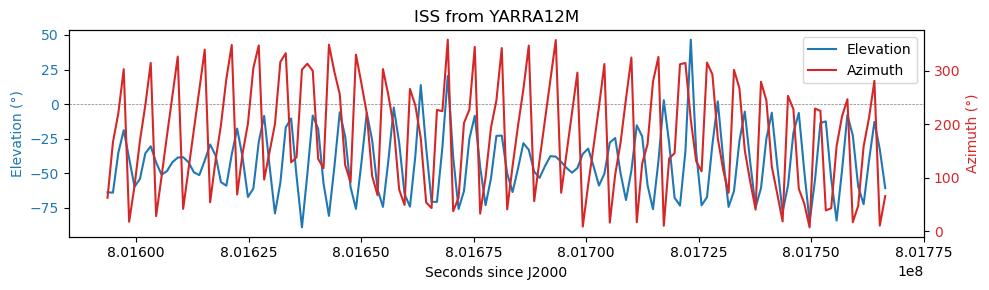

In [ ]:
# Select station names

# station_names =['KATH12M','YARRA12M']
station_names =['YARRA12M']


  
# geodetic_positions = {'KATH12M':[250,-29.0464, 115.3456],'YARRA12M': [50,41.0464, 29.3456] }     altitude, latitude, longitude
geodetic_positions = {'YARRA12M': [250,-29.0464, 115.3456]}

# Select the global frame and orientation 
global_frame_origin = 'Earth'
global_frame_orientation = 'J2000'


# Initializing TLE from celestrack
tle_ISS_line1 = "1 25544U 98067A   25147.20450743  .00010885  00000+0  20003-3 0  9993"
tle_ISS_line2 = "2 25544  51.6384  51.0343 0002206 149.5344 343.0812 15.49769564511908"


tle_ISS = Tle(           
    tle_ISS_line1,
    tle_ISS_line2,)

# Defining time window of simulation from TLE epoch to Tle epoch + 1 day
tle_epoch = tle_ISS_line1[18:32]
start_epoch = tle_epoch_to_datetime(tle_epoch)
end_epoch = start_epoch + timedelta(days=2)
start_epoch_string = start_epoch.strftime("%Y-%m-%d %H:%M:%S")
end_epoch_string = end_epoch.strftime("%Y-%m-%d %H:%M:%S")

print(start_epoch_string)

plot_combined_elevation(
    'ISS (ZARYA)',
    tle_ISS,
    station_names,
    start_epoch = start_epoch_string,
    end_epoch = end_epoch_string,
    time_step= '20m',
    geodetic_positions=geodetic_positions,
    custom_ephemeris = None
)

In [25]:
from skyfield.api import Topos, load

lines = [
    "ISS (ZARYA)",
    "1 25544U 98067A   25147.20450743  .00010885  00000+0  20003-3 0  9993",
    "2 25544  51.6384  51.0343 0002206 149.5344 343.0812 15.49769564511908"
]

satellites = load.tle_file(lines=lines)
satellite = satellites[0]

ts = load.timescale()
observer = Topos('37.7749 N', '122.4194 W')  # Example: San Francisco

for minute in range(0, 60, 5):  # check every 5 minutes for 1 hour
    t = ts.utc(2024, 5, 27, 12, minute)
    difference = satellite - observer
    topocentric = difference.at(t)
    alt, az, distance = topocentric.altaz()
    print(f"{t.utc_iso()} | Alt: {alt.degrees:.2f}° | Az: {az.degrees:.2f}°")



ModuleNotFoundError: No module named 'skyfield'

In [18]:
tle_ISS_line1 = "1 25544U 98067A   25147.20450743  .00010885  00000+0  20003-3 0  9993"
tle_ISS_line2 = "2 25544  51.6384  51.0343 0002206 149.5344 343.0812 15.49769564511908"

tle_epoch = tle_ISS_line1[18:32]

start_epoch = tle_epoch_to_datetime(tle_epoch)
print(start_epoch)


print(start_epoch.strftime("%Y-%m-%d %H:%M:%S"))

2025-05-27 04:54:29
2025-05-27 04:54:29
